# Practicant amb training i test sets

**Descripció**
Familiaritza't amb la programació científica mitjantçant la llibreria SKLearn / Scikitlearn.

In [104]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA

## Nivell 1

### Exercici 1
Parteix el conjunt de dadesDelayedFlights.csv en train i test. Estudia els dos conjunts per separat, a nivell descriptiu.

In [4]:
PATH = '../data/'
fitxer = PATH + 'CleanDelayedFlights.pickle'

dfdelays = pd.read_pickle(fitxer)

In [6]:
dfdelays.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'carrier_name', 'Name_Origin', 'Name_Dest', 'TZ_Origin', 'TZ_Dest',
       'dia_add', 'no_vol', 'endarrerit', 'CRSElapsedTime_c',
       'ActualElapsedTime_c', 'DepartureTime', 'CRSDepartureTime',
       'ArrivalTime', 'CRSArrivalTime', 'Dep_hourlyf', 'Dep_dailyf',
       'Arr_dailyf', 'Arr_hourlyf'],
      dtype='object')

In [8]:
columnes = ['DayOfWeek', 'UniqueCarrier', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
#        'carrier_name', 'Name_Origin', 'Name_Dest', 
       'dia_add', 'no_vol', 'endarrerit', 'CRSElapsedTime_c',
       'ActualElapsedTime_c', 'DepartureTime', 'CRSDepartureTime',
       'ArrivalTime', 'CRSArrivalTime', 'Dep_hourlyf', 'Dep_dailyf',
       'Arr_dailyf', 'Arr_hourlyf']

In [13]:
try:
    X_train, X_test = train_test_split(dfdelays[columnes], test_size=0.15, 
                                       random_state=42, stratify=dfdelays[['Origin','Dest']])
except ValueError as ve:
    print(f'Genera un ValueError per: {str(ve)}')

Genera un ValueError per: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


Veiem que genera un error perquè no pot segmentar per aeroports (Origen i Destí) al haver-hi només 1 vol a algun aeroport. Provarem de fer l'split estratificat amb companyies.

In [14]:
try:
    X_train, X_test = train_test_split(dfdelays[columnes], test_size=0.15, 
                                       random_state=42, stratify=dfdelays['UniqueCarrier'])
except ValueError as ve:
    print(f'Genera un ValueError per: {str(ve)}')

### Estudi dels 2 conjunts per separat

#### Numèriques

In [115]:

desc_train = X_train.describe().T
desc_test = X_test.describe().T
desc_train.columns = [col + '_train' for col in desc_train.columns]
desc_test.columns = [col + '_test' for col in desc_test.columns]

num_cols = X_train.select_dtypes(include=['int','float']).columns.to_list()
pd.concat([dfdelays[num_cols].describe().T, desc_train,desc_test], axis=1).sort_index(axis=1)\
            .style.format("{:.2f}")\
            .set_properties(**{'background-color':'lightyellow'}, subset=desc_test.columns)\
            .set_properties(**{'background-color':'lightgreen'}, subset=desc_train.columns)

,25%,25%_test,25%_train,50%,50%_test,50%_train,75%,75%_test,75%_train,count,count_test,count_train,max,max_test,max_train,mean,mean_test,mean_train,min,min_test,min_train,std,std_test,std_train
DayOfWeek,2.00,2.00,2.00,4.00,4.00,4.00,6.00,6.00,6.00,1928371.00,289256.00,1639115.00,7.00,7.00,7.00,3.98,3.98,3.99,1.00,1.00,1.00,2.00,2.00,2.00
AirTime,58.00,58.00,58.00,90.00,90.00,90.00,137.00,137.00,137.00,1928371.00,289256.00,1639115.00,1091.00,655.00,1091.00,108.28,108.26,108.28,1.00,1.00,1.00,68.64,68.63,68.64
ArrDelay,9.00,9.00,9.00,24.00,24.00,24.00,56.00,56.00,56.00,1928371.00,289256.00,1639115.00,2461.00,1510.00,2461.00,42.20,42.06,42.22,-109.00,-68.00,-109.00,56.78,56.70,56.80
DepDelay,12.00,12.00,12.00,24.00,24.00,24.00,53.00,53.00,53.00,1928371.00,289256.00,1639115.00,2467.00,1518.00,2467.00,43.09,42.94,43.12,6.00,6.00,6.00,53.27,53.19,53.28
Distance,338.00,338.00,338.00,606.00,606.00,606.00,997.00,997.00,997.00,1928371.00,289256.00,1639115.00,4962.00,4962.00,4962.00,764.95,764.71,764.99,11.00,11.00,11.00,573.89,573.81,573.90
TaxiIn,4.00,4.00,4.00,6.00,6.00,6.00,8.00,8.00,8.00,1928371.00,289256.00,1639115.00,240.00,186.00,240.00,6.81,6.81,6.81,0.00,0.00,0.00,5.27,5.20,5.28
TaxiOut,10.00,10.00,10.00,14.00,14.00,14.00,21.00,21.00,21.00,1928371.00,289256.00,1639115.00,422.00,345.00,422.00,18.22,18.25,18.21,0.00,0.00,0.00,14.31,14.39,14.29
no_vol,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1928371.00,289256.00,1639115.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CRSElapsedTime_c,81.00,81.00,81.00,116.00,116.00,116.00,165.00,165.00,165.00,1928371.00,289256.00,1639115.00,660.00,660.00,660.00,134.04,134.03,134.04,8.00,15.00,8.00,71.25,71.26,71.25
ActualElapsedTime_c,80.00,80.00,80.00,116.00,116.00,116.00,165.00,165.00,165.00,1928371.00,289256.00,1639115.00,1114.00,711.00,1114.00,133.31,133.31,133.31,14.00,15.00,14.00,72.06,72.06,72.06


Observem que no hi ha diferències significatives entre els valors del train i el test (el màxim i el mínim d'algun valor, però es esperable)

#### Dates

In [93]:
time_cols = X_train.select_dtypes(include=['datetime']).columns.to_list()

desc_train = X_train[time_cols].agg(['min','max']).T
desc_test = X_test[time_cols].agg(['min','max']).T

desc_train.columns = [col + '_train' for col in desc_train.columns]
desc_test.columns = [col + '_test' for col in desc_test.columns]

pd.concat([dfdelays[time_cols].agg(['min','max']).T,desc_train, desc_test], axis=1).sort_index(axis=1)\
            .style.set_properties(**{'background-color':'lightyellow'}, subset=desc_test.columns)\
            .set_properties(**{'background-color':'lightgreen'}, subset=desc_train.columns)

,max,max_test,max_train,min,min_test,min_train
DepartureTime,2008-12-31 23:58:00,2008-12-31 23:58:00,2008-12-31 23:56:00,2008-01-01 00:01:00,2008-01-01 00:13:00,2008-01-01 00:01:00
CRSDepartureTime,2008-12-31 23:59:00,2008-12-31 23:59:00,2008-12-31 23:59:00,2008-01-01 00:25:00,2008-01-01 03:25:00,2008-01-01 00:25:00
ArrivalTime,2009-01-01 06:05:00,2009-01-01 05:13:00,2009-01-01 06:05:00,2008-01-01 00:57:00,2008-01-01 01:26:00,2008-01-01 00:57:00
CRSArrivalTime,2009-01-01 05:50:00,2009-01-01 05:25:00,2009-01-01 05:50:00,2008-01-01 03:35:00,2008-01-01 06:38:00,2008-01-01 03:35:00


#### Categòriques

In [90]:
cat_cols = X_train.select_dtypes(include=['object']).columns.to_list()

# X_train.value_counts(subset=cat_cols)
desc_cat = pd.concat([dfdelays[cat_cols].nunique(),X_train[cat_cols].nunique(),X_test[cat_cols].nunique()],axis=1)
desc_cat.columns = ['total','train','test']
desc_cat.style.set_properties(**{'background-color':'lightyellow'}, subset='test')\
            .set_properties(**{'background-color':'lightgreen'}, subset='train')



,total,train,test
UniqueCarrier,20,20,20
Origin,303,303,298
Dest,302,302,301


Veiem que hi ha algun aeroport que no està en el test, com era d'esperar.

## Nivell 2
### Exercici 2
Aplica algun procés de transformació (estandarditzar les dades numèriques, crear columnes dummies, polinomis...).

In [95]:
print(columnes)

['DayOfWeek', 'UniqueCarrier', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'dia_add', 'no_vol', 'endarrerit', 'CRSElapsedTime_c', 'ActualElapsedTime_c', 'DepartureTime', 'CRSDepartureTime', 'ArrivalTime', 'CRSArrivalTime', 'Dep_hourlyf', 'Dep_dailyf', 'Arr_dailyf', 'Arr_hourlyf']


#### Estandaritzem les dades numériques

In [103]:
sc = StandardScaler()

train_std_transf = sc.fit_transform(X_train[num_cols])
test_std_transf = sc.transform(X_test[num_cols])

#### OneHotEncoding variables categòriques

In [107]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

train_ohe = ohe.fit_transform(X_train[cat_cols])
test_ohe = ohe.transform(X_test[cat_cols])

In [108]:
train_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
ohe.get_feature_names(input_features=cat_cols)

array(['UniqueCarrier_9E', 'UniqueCarrier_AA', 'UniqueCarrier_AQ',
       'UniqueCarrier_AS', 'UniqueCarrier_B6', 'UniqueCarrier_CO',
       'UniqueCarrier_DL', 'UniqueCarrier_EV', 'UniqueCarrier_F9',
       'UniqueCarrier_FL', 'UniqueCarrier_HA', 'UniqueCarrier_MQ',
       'UniqueCarrier_NW', 'UniqueCarrier_OH', 'UniqueCarrier_OO',
       'UniqueCarrier_UA', 'UniqueCarrier_US', 'UniqueCarrier_WN',
       'UniqueCarrier_XE', 'UniqueCarrier_YV', 'Origin_ABE', 'Origin_ABI',
       'Origin_ABQ', 'Origin_ABY', 'Origin_ACK', 'Origin_ACT',
       'Origin_ACV', 'Origin_ACY', 'Origin_ADK', 'Origin_ADQ',
       'Origin_AEX', 'Origin_AGS', 'Origin_AKN', 'Origin_ALB',
       'Origin_ALO', 'Origin_AMA', 'Origin_ANC', 'Origin_ASE',
       'Origin_ATL', 'Origin_ATW', 'Origin_AUS', 'Origin_AVL',
       'Origin_AVP', 'Origin_AZO', 'Origin_BDL', 'Origin_BET',
       'Origin_BFL', 'Origin_BGM', 'Origin_BGR', 'Origin_BHM',
       'Origin_BIL', 'Origin_BIS', 'Origin_BJI', 'Origin_BLI',
       'Origin_BMI'

In [114]:
ohe.inverse_transform(train_ohe)

array([['WN', 'ABQ', 'LAS'],
       ['EV', 'DHN', 'ATL'],
       ['AA', 'DFW', 'ORD'],
       ...,
       ['WN', 'BWI', 'MHT'],
       ['OO', 'ORD', 'SAV'],
       ['CO', 'EWR', 'LAX']], dtype=object)

### Noves columnes

## Nivell 3
### Exercici 3
Resumeix les noves columnes generades de manera estadística i gràfica

In [121]:
dftrain_std_transf = pd.DataFrame(train_std_transf, columns=num_cols)
dftest_std_transf = pd.DataFrame(test_std_transf, columns=num_cols) 

desc_train = dftrain_std_transf.describe().T
desc_test = dftest_std_transf.describe().T
desc_train.columns = [col + '_train' for col in desc_train.columns]
desc_test.columns = [col + '_test' for col in desc_test.columns]

num_cols = X_train.select_dtypes(include=['int','float']).columns.to_list()
pd.concat([dfdelays[num_cols].describe().T, desc_train,desc_test], axis=1).sort_index(axis=1)\
            .style.format("{:.2f}")\
            .set_properties(**{'background-color':'lightyellow'}, subset=desc_test.columns)\
            .set_properties(**{'background-color':'lightgreen'}, subset=desc_train.columns)

,25%,25%_test,25%_train,50%,50%_test,50%_train,75%,75%_test,75%_train,count,count_test,count_train,max,max_test,max_train,mean,mean_test,mean_train,min,min_test,min_train,std,std_test,std_train
DayOfWeek,2.00,-0.99,-0.99,4.00,0.01,0.01,6.00,1.01,1.01,1928371.00,289256.00,1639115.00,7.00,1.51,1.51,3.98,-0.00,-0.00,1.00,-1.50,-1.50,2.00,1.00,1.00
AirTime,58.00,-0.73,-0.73,90.00,-0.27,-0.27,137.00,0.42,0.42,1928371.00,289256.00,1639115.00,1091.00,7.96,14.32,108.28,-0.00,0.00,1.00,-1.56,-1.56,68.64,1.00,1.00
ArrDelay,9.00,-0.58,-0.58,24.00,-0.32,-0.32,56.00,0.24,0.24,1928371.00,289256.00,1639115.00,2461.00,25.84,42.58,42.20,-0.00,0.00,-109.00,-1.94,-2.66,56.78,1.00,1.00
DepDelay,12.00,-0.58,-0.58,24.00,-0.36,-0.36,53.00,0.19,0.19,1928371.00,289256.00,1639115.00,2467.00,27.68,45.49,43.09,-0.00,0.00,6.00,-0.70,-0.70,53.27,1.00,1.00
Distance,338.00,-0.74,-0.74,606.00,-0.28,-0.28,997.00,0.40,0.40,1928371.00,289256.00,1639115.00,4962.00,7.31,7.31,764.95,-0.00,-0.00,11.00,-1.31,-1.31,573.89,1.00,1.00
TaxiIn,4.00,-0.53,-0.53,6.00,-0.15,-0.15,8.00,0.22,0.22,1928371.00,289256.00,1639115.00,240.00,33.94,44.16,6.81,-0.00,-0.00,0.00,-1.29,-1.29,5.27,0.98,1.00
TaxiOut,10.00,-0.57,-0.57,14.00,-0.29,-0.29,21.00,0.20,0.20,1928371.00,289256.00,1639115.00,422.00,22.86,28.25,18.22,0.00,0.00,0.00,-1.27,-1.27,14.31,1.01,1.00
no_vol,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1928371.00,289256.00,1639115.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CRSElapsedTime_c,81.00,-0.74,-0.74,116.00,-0.25,-0.25,165.00,0.43,0.43,1928371.00,289256.00,1639115.00,660.00,7.38,7.38,134.04,-0.00,-0.00,8.00,-1.67,-1.77,71.25,1.00,1.00
ActualElapsedTime_c,80.00,-0.74,-0.74,116.00,-0.24,-0.24,165.00,0.44,0.44,1928371.00,289256.00,1639115.00,1114.00,8.02,13.61,133.31,0.00,-0.00,14.00,-1.64,-1.66,72.06,1.00,1.00


/Users/xavier/opt/anaconda3/envs/udacity_dsnd/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xavier/opt/anaconda3/envs/udacity_dsnd/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DayOfWeek'>

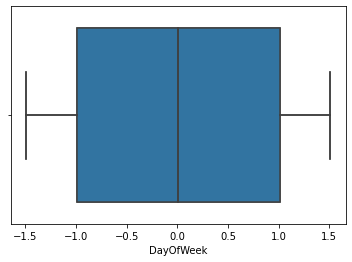

In [133]:
sns.boxplot(dftrain_std_transf['DayOfWeek'],  )
sns.boxplot(dftest_std_transf['DayOfWeek'])

col: DayOfWeek


AttributeError: 'numpy.ndarray' object has no attribute 'xaxis'

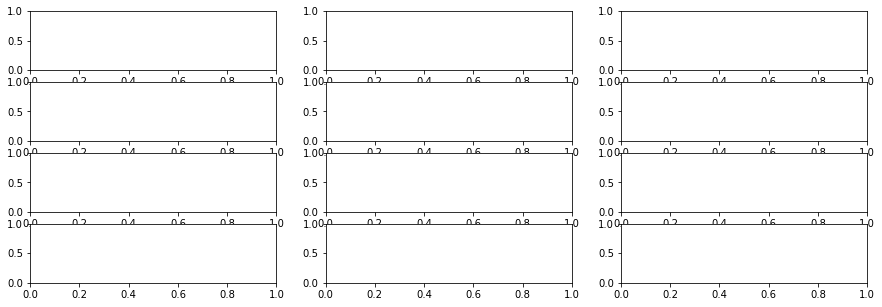

In [124]:
fig, axes = plt.subplots(len(num_cols)//3, 3, figsize=(15,5))

for i, col in enumerate(num_cols):
    print(f'col: {col}')
    g = sns.kdeplot(ax=axes[i], x=dftrain_std_transf[col])